In [1]:
from xmitgcm import open_mdsdataset
import xarray as xr
import numpy as np
import xgcm
import datetime
import os
from matplotlib import pyplot as plt 
from scipy import interpolate
import warnings; warnings.simplefilter('ignore')
from numba import jit

from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, AdvectionRK4_3D, ErrorCode
import math
from datetime import timedelta
from operator import attrgetter

%matplotlib inline
plt.rcParams['figure.figsize'] = (15,10)
plt.rcParams['font.size'] = 16
plt.rcParams['text.usetex'] = False

from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:41363 Dashboard: http://127.0.0.1:39209/status,Cluster Workers: 9 Cores: 72 Memory: 134.72 GB


## Upload dataset

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,10)
plt.rcParams['font.size'] = 16
plt.rcParams['text.usetex'] = False

run = 'layers0.15'


plot_dir = '/glade/u/home/myoungs/Figures/'+datetime.date.today().isoformat()+'/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

#for x in run:
    ## read in data #######
      
data_dir = '/glade/scratch/myoungs/'+run

print(data_dir)
    
   
ds = open_mdsdataset(data_dir,prefix=['DIAG','DIAGLayer','DIAGSurf'],delta_t=600)
#ds =  open_mdsdataset(data_dir,prefix=['DIAGLayer','DIAG'],delta_t=600)
#                        # ignore_unknown_vars==True)#,iters='377225') # ,'DIAGTracer'
grid = xgcm.Grid(ds, periodic=['X'])
#gridmean = xgcm.Grid(dsmean, periodic=['X'])
ds

/glade/scratch/myoungs/layers0.15


<xarray.Dataset>
Dimensions:              (XC: 400, XG: 400, YC: 204, YG: 204, Z: 32, Zl: 32, Zp1: 33, Zu: 32, layer_1TH_bounds: 50, layer_1TH_center: 49, layer_1TH_interface: 48, time: 365)
Coordinates:
    iter                 (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time                 (time) int64 36744192000 36744624000 ... 36901440000
  * XC                   (XC) >f4 5000.0 15000.0 25000.0 ... 3985000.0 3995000.0
  * YC                   (YC) >f4 5000.0 15000.0 25000.0 ... 2025000.0 2035000.0
  * XG                   (XG) >f4 0.0 10000.0 20000.0 ... 3980000.0 3990000.0
  * YG                   (YG) >f4 0.0 10000.0 20000.0 ... 2020000.0 2030000.0
  * Z                    (Z) >f4 -5.0 -15.0 -25.0 ... -3300.0 -3580.0 -3860.0
  * Zp1                  (Zp1) >f4 0.0 -10.0 -20.0 ... -3440.0 -3720.0 -4000.0
  * Zu                   (Zu) >f4 -10.0 -20.0 -30.0 ... -3440.0 -3720.0 -4000.0
  * Zl                   (Zl) >f4 0.0 -10.0 -20.0 ... -3160.0 -3440.0 -3720.0
    rA                   (YC, XC) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    dxG                  (YG, XC) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    dyG                  (YC, XG) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    Depth                (YC, XC) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    rAz                  (YG, XG) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    dxC                  (YC, XG) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    dyC                  (YG, XC) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    rAw                  (YC, XG) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    rAs                  (YG, XC) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    drC                  (Zp1) >f4 dask.array<chunksize=(33,), meta=np.ndarray>
    drF                  (Z) >f4 dask.array<chunksize=(32,), meta=np.ndarray>
    PHrefC               (Z) >f4 dask.array<chunksize=(32,), meta=np.ndarray>
    PHrefF               (Zp1) >f4 dask.array<chunksize=(33,), meta=np.ndarray>
    hFacC                (Z, YC, XC) >f4 dask.array<chunksize=(32, 204, 400), meta=np.ndarray>
    hFacW                (Z, YC, XG) >f4 dask.array<chunksize=(32, 204, 400), meta=np.ndarray>
    hFacS                (Z, YG, XC) >f4 dask.array<chunksize=(32, 204, 400), meta=np.ndarray>
    maskC                (Z, YC, XC) bool dask.array<chunksize=(32, 204, 400), meta=np.ndarray>
    maskW                (Z, YC, XG) bool dask.array<chunksize=(32, 204, 400), meta=np.ndarray>
    maskS                (Z, YG, XC) bool dask.array<chunksize=(32, 204, 400), meta=np.ndarray>
  * layer_1TH_bounds     (layer_1TH_bounds) >f4 0.0 0.1632653 ... 7.836735 8.0
  * layer_1TH_center     (layer_1TH_center) float32 0.08163265 ... 7.9183674
  * layer_1TH_interface  (layer_1TH_interface) >f4 0.1632653 ... 7.836735
Data variables:
    LaVH1TH              (time, layer_1TH_center, YG, XC) float32 dask.array<chunksize=(1, 49, 204, 400), meta=np.ndarray>
    LaHs1TH              (time, layer_1TH_center, YG, XC) float32 dask.array<chunksize=(1, 49, 204, 400), meta=np.ndarray>
    LaVa1TH              (time, layer_1TH_center, YG, XC) float32 dask.array<chunksize=(1, 49, 204, 400), meta=np.ndarray>
    LaUH1TH              (time, layer_1TH_center, YC, XG) float32 dask.array<chunksize=(1, 49, 204, 400), meta=np.ndarray>
    LaUa1TH              (time, layer_1TH_center, YC, XG) float32 dask.array<chunksize=(1, 49, 204, 400), meta=np.ndarray>
    LaHw1TH              (time, layer_1TH_center, YC, XG) float32 dask.array<chunksize=(1, 49, 204, 400), meta=np.ndarray>
    TRELAX               (time, YC, XC) float32 dask.array<chunksize=(1, 204, 400), meta=np.ndarray>
    oceTAUX              (time, YC, XG) float32 dask.array<chunksize=(1, 204, 400), meta=np.ndarray>
    ETAN                 (time, YC, XC) float32 dask.array<chunksize=(1, 204, 400), meta=np.ndarray>
    THETA                (time, Z, 

In [3]:
dst = xr.open_dataset('TonsOfParticles300.nc')
dst

print(dst.time[0])

ValueError: unable to decode time units 'seconds since -149296147419103232 nanoseconds' with calendar 'np_timedelta64'. Try opening your dataset with decode_times=False.

## Remove parcels that don't get to the end of the domain

In [15]:
for tra in range(np.shape(dst.time)[0]):
     if np.max(dst.lon[tra]) < 3.9e6:
            dst.lon[tra] = np.nan
            dst.lat[tra] = np.nan
            dst.t[tra] = np.nan
            dst.z[tra] = np.nan
            dst.meandisp[tra] = np.nan
            dst.totdisp[tra] = np.nan
            dst.geodisp[tra] = np.nan
            dst.meangeodisp[tra] = np.nan
            dst.btdisp[tra] = np.nan
            dst.meanbtdisp[tra] = np.nan

## Subsample based on temperature

In [16]:
maxtemp2 = 4
mintemp2 = 3

lonvec = np.array(dst.lon.where(dst.t[:,0]>= mintemp2).where(dst.t[:,0]<maxtemp2)).flatten()
lonvec  = lonvec[~np.isnan(lonvec)]

latvec = np.array(dst.lat.where(dst.t[:,0]>= mintemp2).where(dst.t[:,0]<maxtemp2)).flatten()
latvec  = latvec[~np.isnan(latvec)]

dispvec = np.array((dst.z-dst.z[:,0]).where(dst.t[:,0]>= mintemp2).where(dst.t[:,0]<maxtemp2)).flatten()
dispvec  = dispvec[~np.isnan(dispvec)]

tempvec = np.array((dst.t-dst.t[:,0]).where(dst.t[:,0]>= mintemp2).where(dst.t[:,0]<maxtemp2)).flatten()
tempvec  = tempvec[~np.isnan(tempvec)]

meandispvec = np.array(dst.meandisp.where(dst.t[:,0]>= mintemp2).where(dst.t[:,0]<maxtemp2)).flatten()
meandispvec  = meandispvec[~np.isnan(meandispvec)]

geodispvec = np.array(dst.geodisp.where(dst.t[:,0]>= mintemp2).where(dst.t[:,0]<maxtemp2)).flatten()
geodispvec  = geodispvec[~np.isnan(geodispvec)]

btdispvec = np.array(dst.btdisp.where(dst.t[:,0]>= mintemp2).where(dst.t[:,0]<maxtemp2)).flatten()
btdispvec  = btdispvec[~np.isnan(btdispvec)]

meangeodispvec = np.array(dst.meangeodisp.where(dst.t[:,0]>= mintemp2).where(dst.t[:,0]<maxtemp2)).flatten()
meangeodispvec  = meangeodispvec[~np.isnan(meangeodispvec)]

meanbtdispvec = np.array(dst.meanbtdisp.where(dst.t[:,0]>= mintemp2).where(dst.t[:,0]<maxtemp2)).flatten()
meanbtdispvec  = meanbtdispvec[~np.isnan(meanbtdispvec)]


## do objective mapping

In [17]:
@jit
def mindist(x,y,lonv,latv):
    minimum = min(np.sqrt(np.square(x-lonvec) + np.square(y-latvec)))
    return minimum

#vmindist = np.vectorize(mindist,excluded=('lonv','latv'))



In [18]:
# calculate if the point is too far away from a particle
xgrid, ygrid = np.meshgrid(np.array(ds.XC), np.array(ds.YC))
#mask = vmindist(xgrid,ygrid,lonvec,latvec)> 30000

In [19]:
mask = xgrid*0 + 1
for i in range(400):
    print(i)
    for j in range(204):
        if mindist(xgrid[j,i],ygrid[j,i],lonvec,latvec)>30000:
            mask[j,i] = np.nan
            
dispgrid = interpolate.griddata((lonvec,latvec),dispvec,(xgrid,ygrid),method='linear')
tempgrid = interpolate.griddata((lonvec,latvec),tempvec,(xgrid,ygrid),method='linear')
meandispgrid = interpolate.griddata((lonvec,latvec),meandispvec,(xgrid,ygrid),method='linear')
geodispgrid = interpolate.griddata((lonvec,latvec),geodispvec,(xgrid,ygrid),method='linear')
meangeodispgrid = interpolate.griddata((lonvec,latvec),meangeodispvec,(xgrid,ygrid),method='linear')
btdispgrid = interpolate.griddata((lonvec,latvec),btdispvec,(xgrid,ygrid),method='linear')
meanbtdispgrid = interpolate.griddata((lonvec,latvec),meanbtdispvec,(xgrid,ygrid),method='linear')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## Plot the things

Text(0.5, 1.0, 'Eddy Displacement (m) 3 to 4 C')

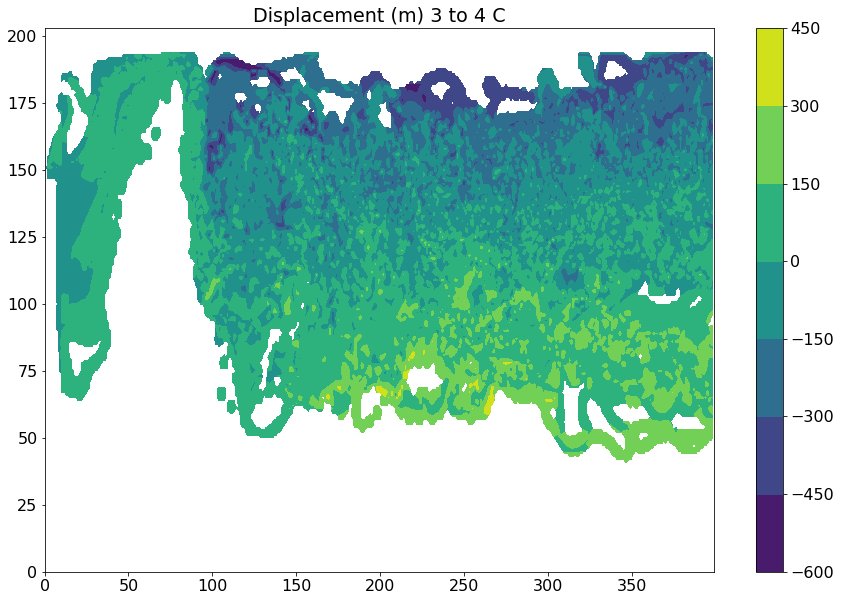

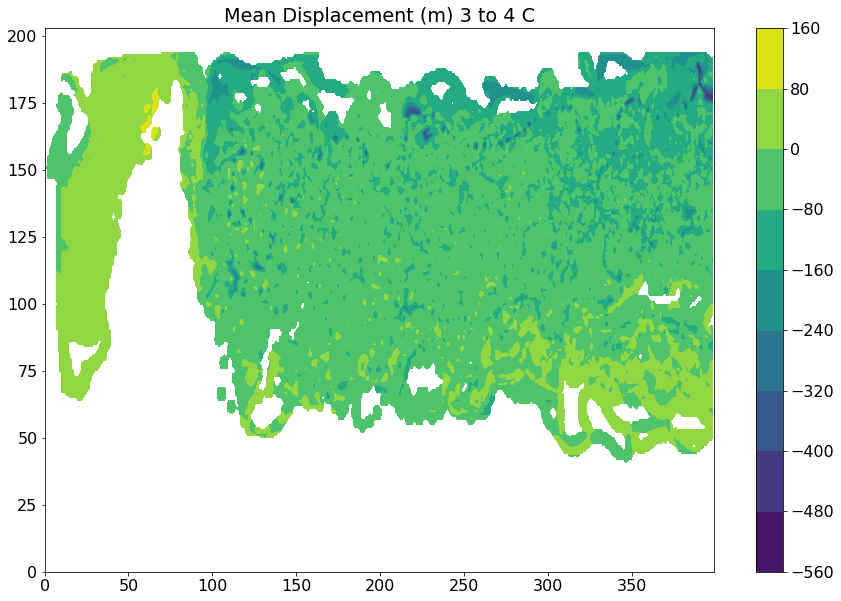

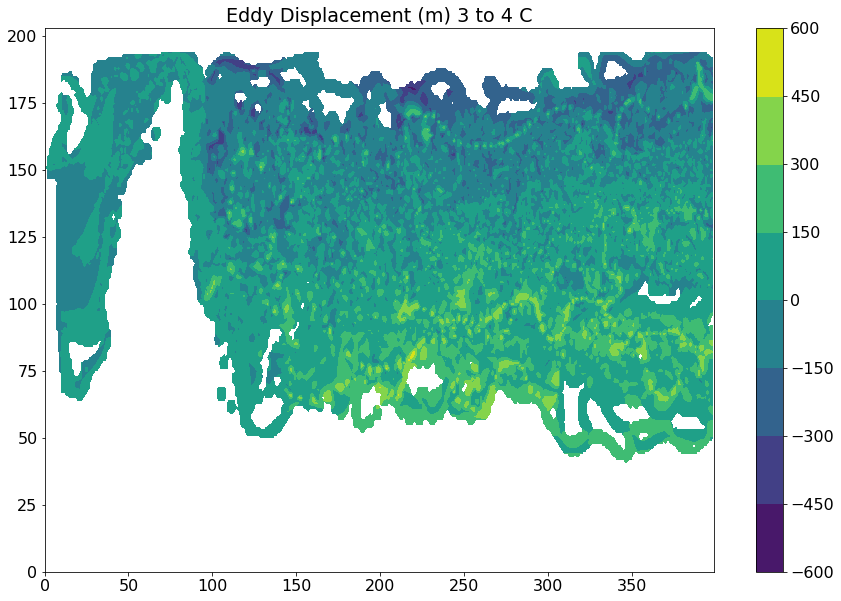

In [20]:
plt.figure()
plt.contourf(dispgrid*mask)
plt.colorbar()

plt.title('Displacement (m) %g to %g C' %(mintemp2, maxtemp2))
#plt.savefig(plot_dir+'Displacement354'+'.eps')


plt.figure()
plt.contourf(meandispgrid*mask)
plt.colorbar()
plt.title('Mean Displacement (m) %g to %g C' %(mintemp2, maxtemp2))
#plt.savefig(plot_dir+'MeanDisplacement354'+'.eps')

plt.figure()
plt.contourf((dispgrid-meandispgrid)*mask)
plt.colorbar()
plt.title('Eddy Displacement (m) %g to %g C' %(mintemp2, maxtemp2))
#plt.savefig(plot_dir+'MeanDisplacement354'+'.eps')

Text(0.5, 1.0, 'Ageostrophic Displacement (m) 3 to 4 C')

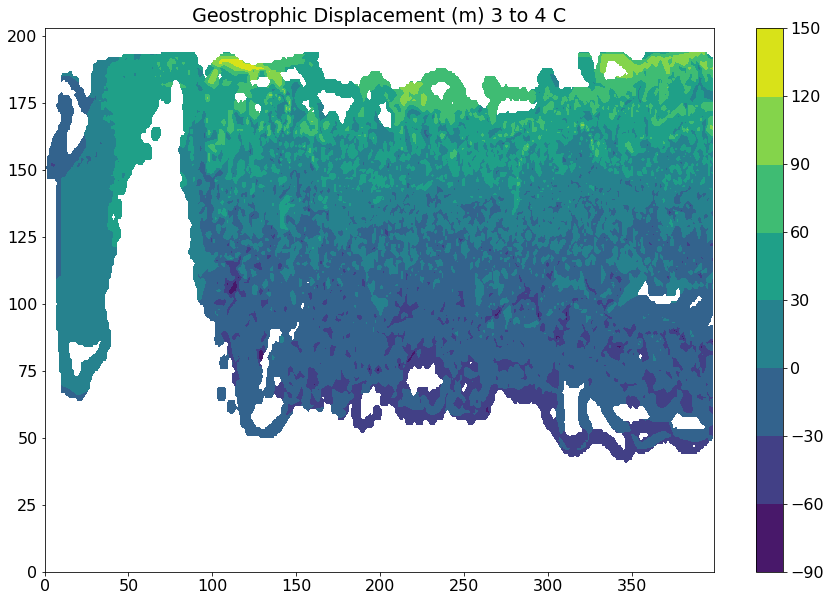

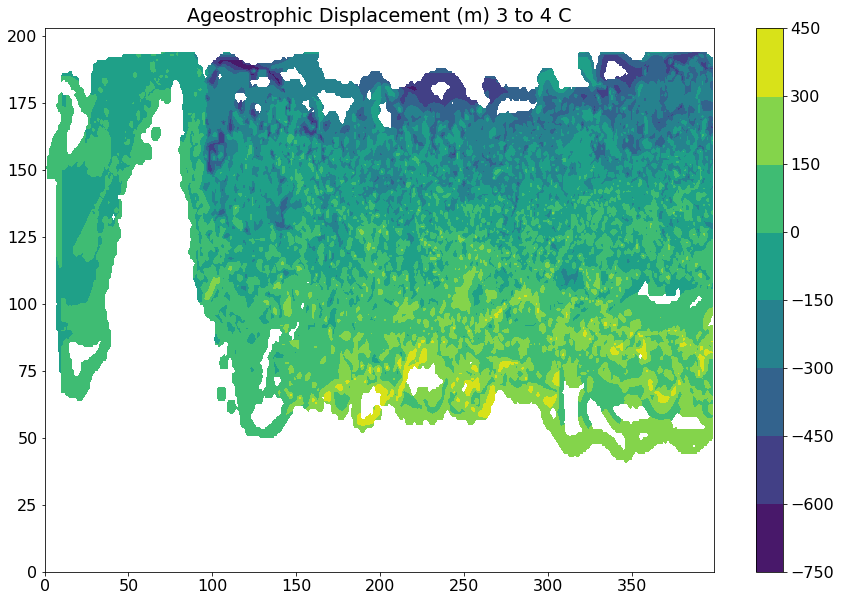

In [21]:
plt.figure()
plt.contourf(geodispgrid*mask)
plt.colorbar()
plt.title('Geostrophic Displacement (m) %g to %g C' %(mintemp2, maxtemp2))
#plt.savefig(plot_dir+'MeanDisplacement354'+'.eps')

plt.figure()
plt.contourf((dispgrid-geodispgrid)*mask)
plt.colorbar()
plt.title('Ageostrophic Displacement (m) %g to %g C' %(mintemp2, maxtemp2))
#plt.savefig(plot_dir+'MeanDisplacement354'+'.eps')

Text(0.5, 1.0, 'Total Baroclinic Displacement (m) 3 to 4 C')

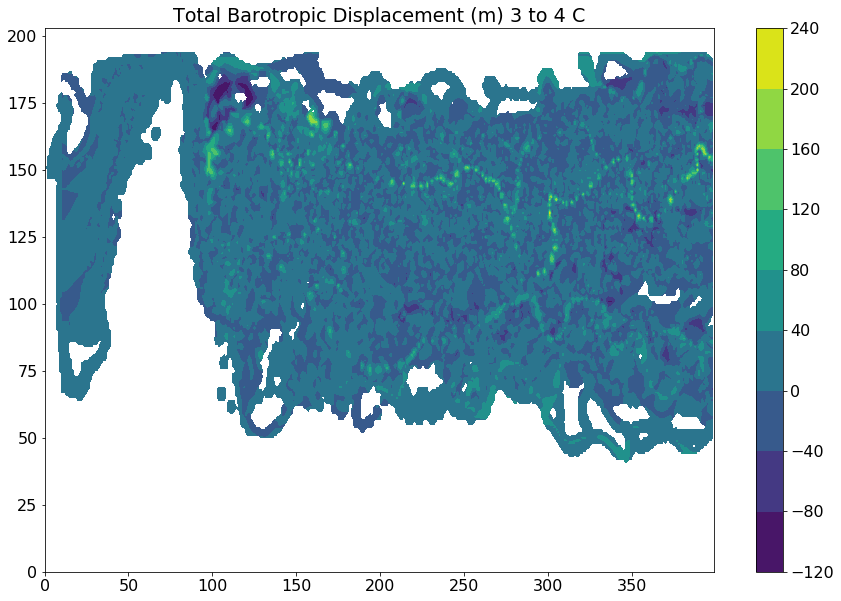

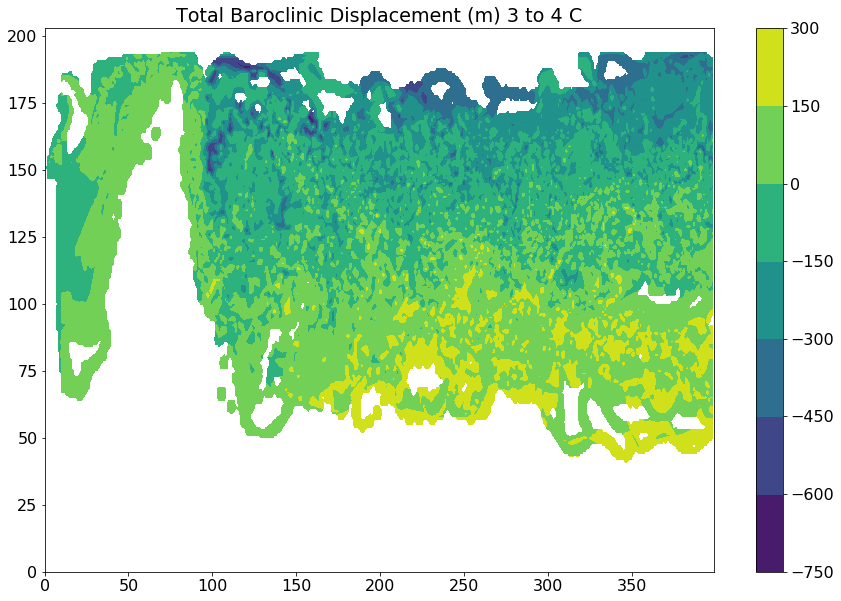

In [22]:
plt.figure()
plt.contourf(btdispgrid*mask)
plt.colorbar()
plt.title('Total Barotropic Displacement (m) %g to %g C' %(mintemp2, maxtemp2))

plt.figure()
plt.contourf((dispgrid-btdispgrid)*mask)
plt.colorbar()
plt.title('Total Baroclinic Displacement (m) %g to %g C' %(mintemp2, maxtemp2))

Text(0.5, 1.0, 'Eddy Baroclinic Displacement (m) 3 to 4 C')

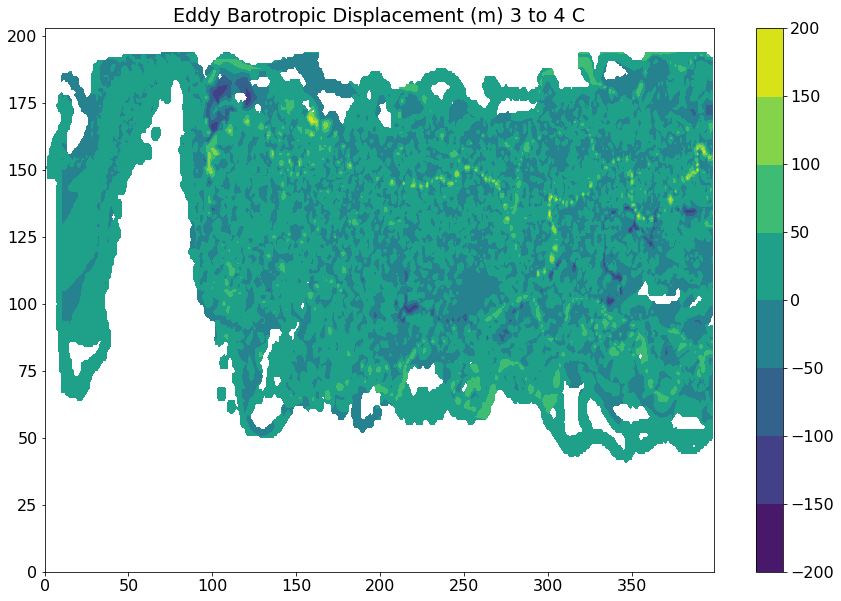

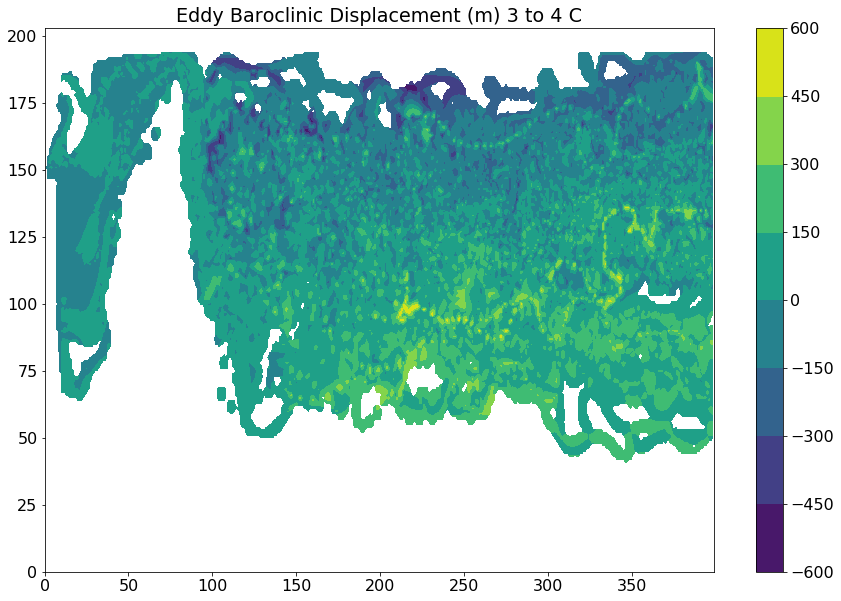

In [23]:
## plot the eddy baroclinic and eddy barotropic displacements
plt.figure()
plt.contourf((btdispgrid-meanbtdispgrid)*mask)
plt.colorbar()
plt.title('Eddy Barotropic Displacement (m) %g to %g C' %(mintemp2, maxtemp2))

plt.figure()
plt.contourf(((dispgrid-meandispgrid)-(btdispgrid-meanbtdispgrid))*mask)
plt.colorbar()
plt.title('Eddy Baroclinic Displacement (m) %g to %g C' %(mintemp2, maxtemp2))


Text(0.5, 1.0, 'Change in Temp (C) 3 to 4 C')

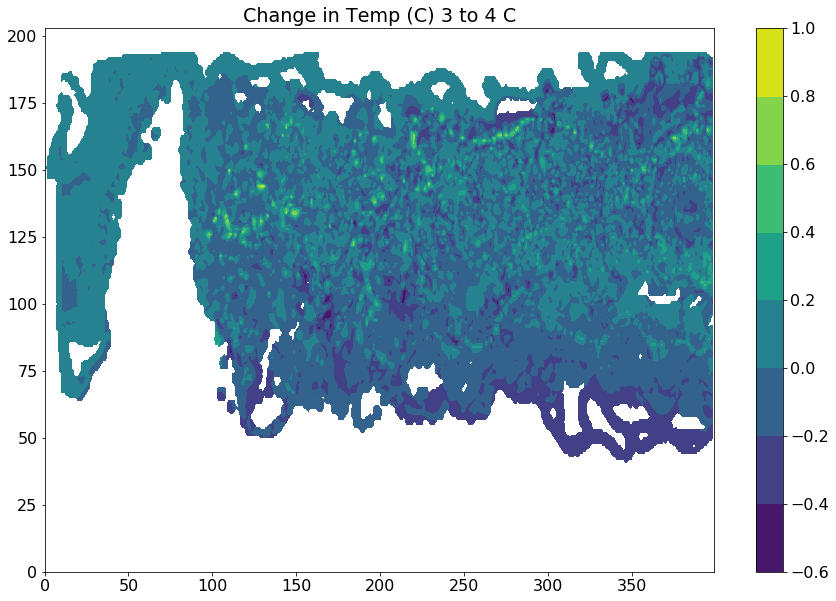

In [24]:
plt.figure()
plt.contourf(tempgrid*mask)
plt.colorbar()
plt.title('Change in Temp (C) %g to %g C' %(mintemp2, maxtemp2))
#plt.savefig(plot_dir+'Temp354'+'.eps')

In [2]:
dst1 = xr.open_dataset('1DayParticles.nc')
dst5 = xr.open_dataset('5DayParticles.nc')
dst10 = xr.open_dataset('10DayParticles.nc')


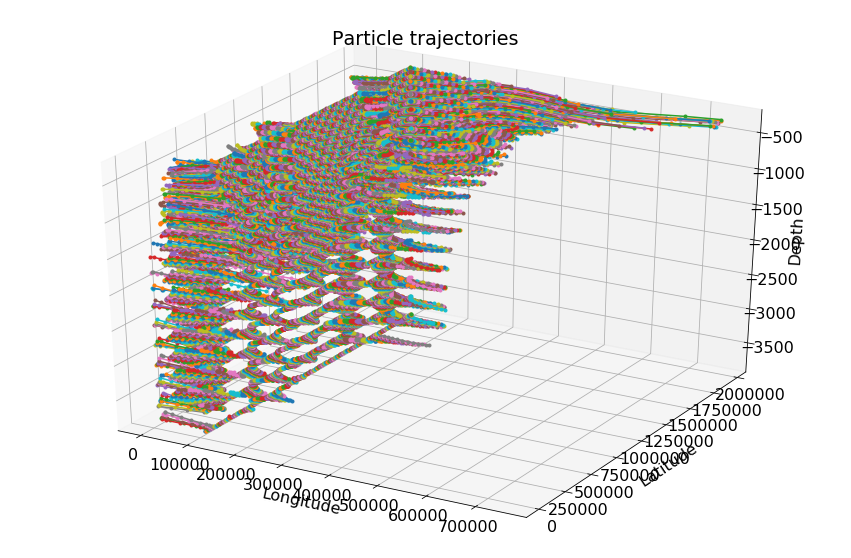

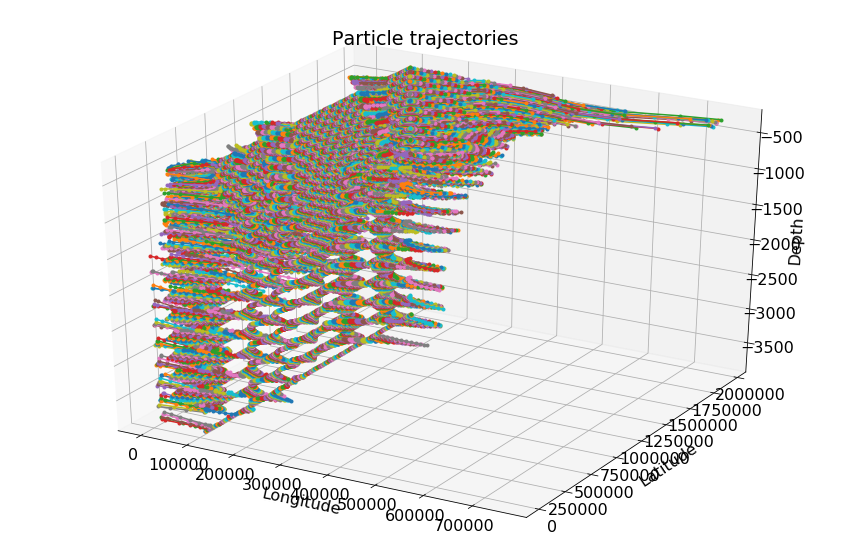

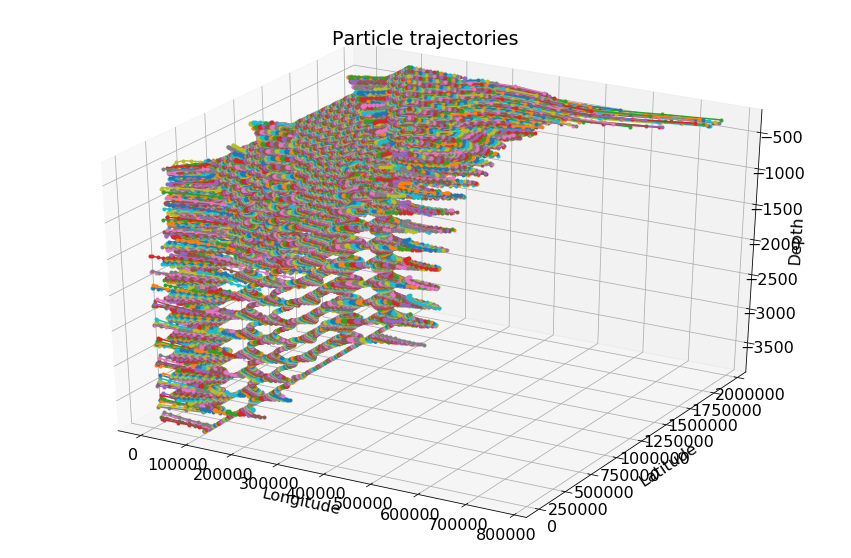

In [3]:
plotTrajectoriesFile('1DayParticles.nc',mode='3d');
plotTrajectoriesFile('5DayParticles.nc',mode='3d');
plotTrajectoriesFile('10DayParticles.nc',mode='3d');